In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load the wine dataset
X, y = load_wine(return_X_y=True)

# Normalize the data in X to be between 0 and 1
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Add a column of ones for the intercept term
X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_ones, y, test_size=0.3, random_state=42)
model = LinearRegression(fit_intercept=False)  # Without intercept (already included in the matrix)
model.fit(X_train, y_train) 

betas = model.coef_  # Includes the intercept and the coefficients

# Calculate X^T * X
XTX = np.dot(X_train.T, X_train)

# Calculate the inverse of X^T * X to obtain Vbeta
Vbeta = np.linalg.inv(XTX)

In [21]:
# Sample from p(y|x_adv)
def sample_y(x_adv, num_samples):

    mean = np.dot(betas, x_adv)
    stddev = np.sqrt(1 + np.dot(x_adv, np.dot(Vbeta, x_adv)))
    return np.random.normal(mean, stddev, size=num_samples)

def g(x_adv, y):

    return np.exp((y / 10) ** 2) - x_adv.sum()

def d_g(x_adv, y):
    return -np.ones(x_adv.shape)  # np.zeros(x_adv.shape)

In [5]:
def d_log_p(x_adv, y):
    sigma2 = 1 + np.dot(x_adv, np.dot(Vbeta, x_adv))
    mu = np.dot(betas, x_adv)

    numerador = sigma2 * (2 * (y[:, np.newaxis] - mu) * betas - 2 * np.dot(Vbeta, x_adv)) + 2 * (y[:, np.newaxis] - mu) ** 2 * np.dot(Vbeta, x_adv)

    return numerador / (2 * sigma2 ** 2)

In [10]:
def log_derivative_trick(x_adv, G, samples_per_iteration):
    y_samples = sample_y(x_adv, samples_per_iteration)
    g_values = g(x_adv, y_samples)
    d_g_values = d_g(x_adv, y_samples)
    d_log_p_values = d_log_p(x_adv, y_samples)
    gradients = 2 * (np.mean(g_values) - G) * np.mean(d_g_values[np.newaxis, :] + g_values[:, np.newaxis] * d_log_p_values, axis=0)
    return gradients, g_values

In [11]:
def reparametrization_trick(x_adv, G, samples_per_iteration):
    eps_samples = np.random.normal(0, 1, size=samples_per_iteration)

    mean = np.dot(betas, x_adv)
    stddev = np.sqrt(1 + np.dot(x_adv, np.dot(Vbeta, x_adv)))

    y_samples = mean + stddev * eps_samples
    g_values = g(x_adv, y_samples)
    
    # Gradient for each component of x_adv
    gradients = 2 * (np.mean(g_values) - G) * np.mean((1 / 50 * y_samples * np.exp(y_samples ** 2 / 100))[np.newaxis, :] * (betas[:, np.newaxis] + 2 * np.dot(Vbeta, x_adv)[:, np.newaxis] * eps_samples), axis=1)
    return gradients, g_values

In [17]:
def attack(x_adv, G, samples_per_iteration=10000, learning_rate=1e-3, num_iterations=1000, epsilon=.1, attack_type="log_derivative_trick"):
    x_0 = x_adv.copy()
    x_adv_values = []
    loss_values = []
    func_values = []

    for _ in range(num_iterations):    
        if attack_type == "log_derivative_trick":
            gradients, g_values = log_derivative_trick(x_adv, G, samples_per_iteration)
        elif attack_type == "reparametrization_trick":
            gradients, g_values = reparametrization_trick(x_adv, G, samples_per_iteration)
        else:
            raise ValueError("Invalid attack type")

        x_adv -= learning_rate * gradients 

        # Projection
        x_adv = x_0 + np.clip(x_adv - x_0, -epsilon, epsilon)

        x_adv_values.append(x_adv.copy())
        loss_values.append((np.mean(g_values) - G) ** 2)
        func_values.append(np.mean(g_values))

    return x_adv_values, loss_values, func_values

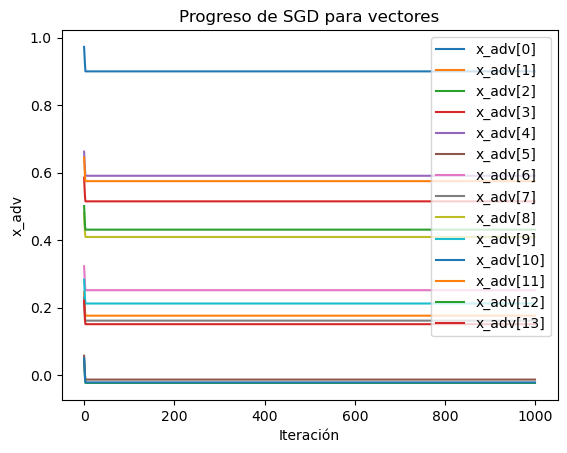

In [22]:
# Attack example
G = 10
x_adv = X_test[17,:].copy()  # un dato cualquiera

x_adv_values, loss_values, func_values = attack(x_adv, G, attack_type="log_derivative_trick")

x_adv_array = np.array(x_adv_values)
for i in range(x_adv_array.shape[1]):
    plt.plot(x_adv_array[:, i], label=f"x_adv[{i}]")

plt.xlabel("Iteración")
plt.ylabel("x_adv")
plt.title("Progreso de SGD para vectores")
plt.legend()
plt.show()

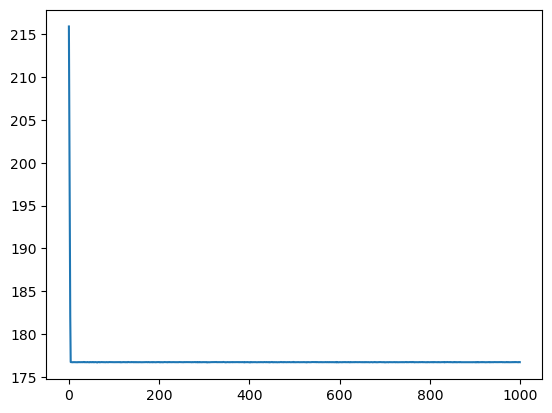

In [23]:
plt.plot(loss_values)

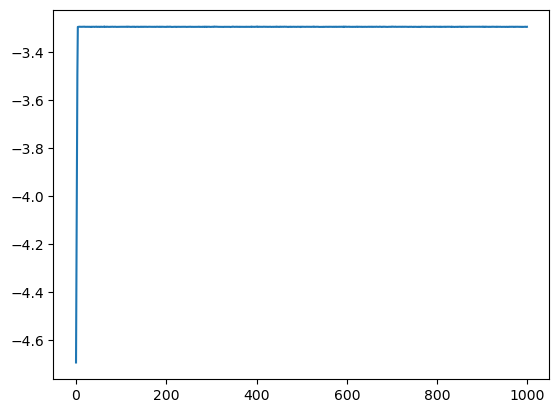

In [24]:
plt.plot(func_values)

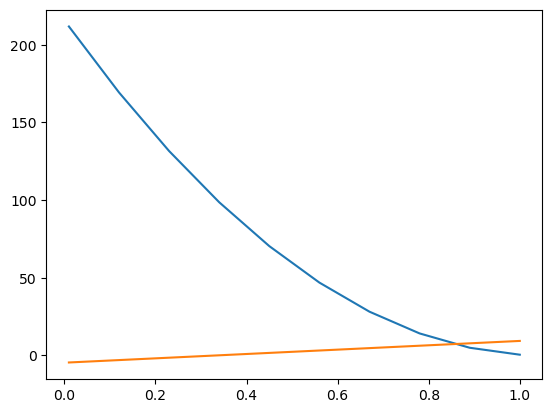

In [28]:
## plot of the difference between G and the function value g(x_adv) against the epsilon value that limits the perturbation
epsilon_values = np.linspace(0.01, 1, 10)    
loss_values = []
f_values = []

for epsilon in epsilon_values:
    x_adv = X_test[17,:].copy()
    _, _, func_values = attack(x_adv, G, epsilon=epsilon, attack_type="log_derivative_trick")
    loss_values.append((np.mean(func_values[-50:]) - G) ** 2)
    f_values.append(np.mean(func_values[-50:]))
    
plt.plot(epsilon_values, loss_values)
plt.plot(epsilon_values, f_values)

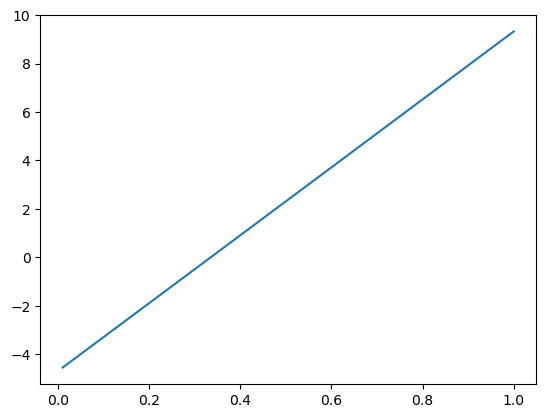

In [29]:
plt.plot(epsilon_values, f_values)


In [ ]:
x_adv = X_test[17,:].copy()

In [ ]:
y_star = 3
ys = []
ysss = []

for epsilon in np.linspace(0, 2, 30):
    beta_dot_x = np.dot(betas, x_adv)
    beta_norm_squared = np.dot(betas, betas)
    x_adv_prime = x_adv + ((y_star - beta_dot_x) / beta_norm_squared) * betas

    if np.linalg.norm(np.dot(y_star - beta_dot_x, betas)) > epsilon * beta_norm_squared: 
        beta_norm_squared = np.linalg.norm(betas)**2
        sign_term = np.sign(y_star - beta_dot_x)
        delta_x_adv = epsilon * (np.dot(y_star - beta_dot_x, betas) / (np.linalg.norm(y_star - beta_dot_x) * np.linalg.norm(betas)))
        x_adv_prime = x_adv + delta_x_adv
    ys.append(np.dot(betas, x_adv_prime))

In [ ]:
plt.scatter(np.linspace(0, 2, 30), ys)
plt.xlabel('$\epsilon$')
plt.ylabel('f(x\')')

### BAYESIAN APPROACH

In [2]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [ ]:
class LinearRegression(object):
    """
    The flat non-informative jeffreys prior for a linear regression model with known
    variance (assumed to be 1) and unknown coefficients. The model is given by y = Xβ + ε, with ε ~ N(0, 1).
    """
    
    def __init__(self):
        """
        Initialize the model.
        """
        self.mu = None
        self.v = None

    def fit(self, X, y):
        """
        Fit the model to the training data.
        """
        
        v_ast = torch.tensor(np.linalg.inv(X.T @ X), dtype=torch.float32)
        mu_ast = torch.tensor(v_ast @ X.T @ y, dtype=torch.float32)
 
        self.mu = mu_ast
        self.v = v_ast

    def predict(self, X_test):
        """
        Predict using the fitted model.
        """
        mean = X_test @ self.mu
        cov = torch.diag(torch.ones(X_test.shape[0])) + X_test.T @ self.v * X_test
        return MultivariateNormal(mean, cov)
        
    def sample_posterior(self, N):
        posterior = MultivariateNormal(self.mu, self.v)
        beta_sample = posterior.sample((N,))
        return beta_sample

